In [50]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score, get_random_solution
from typing import Callable, Tuple
from abc import ABC, abstractmethod
from sortedcontainers import SortedList
import random
import numba

In [51]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [52]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [ ]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)
        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        n = 100
        if indexes is None:
            indexes = np.arange(len(self.indexes))
        selected_indexes = self.indexes[indexes]
        i_vals, j_vals = selected_indexes[:, 0], selected_indexes[:, 1]
        s=np.array(solution)
        i1 = s[(i_vals - 1) % n]
        i2 = s[i_vals]
        j1 = s[j_vals]
        j2 = s[(j_vals + 1) % n]
        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = 100
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        start = i - 1
        end = j + 2
        reversed_segment = set(range(start, end)) 
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in reversed_segment or y in reversed_segment:
                affected.add(k)

        return list(affected)

    
class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)

        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected_list: List[int], indexes=None):
        if indexes is None:
            indexes = np.arange(len(self.indexes)) 
        n = 100
        selected_indexes = self.indexes[indexes]
        indices_i, indices_j = selected_indexes[:, 0], selected_indexes[:, 1]
        i_prev = (indices_i - 1) % n
        i_next = (indices_i + 1) % n
        s=np.array(solution)
        u=np.array(unselected_list)
        node_prev = s[i_prev]
        node_current =s[indices_i]  
        node_next = s[i_next]
        node_unselected = u[indices_j]
        differences = (
            -self.dist_mat[node_prev, node_current]
            - self.dist_mat[node_current, node_next]
            + self.dist_mat[node_prev, node_unselected]
            + self.dist_mat[node_unselected, node_next]
        )
        return differences
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        n = len(solution)
        adjacent_indices = { (i - 1) % n, (i + 1) % n, i }
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in adjacent_indices or y in adjacent_indices:
                affected.add(k)
            if y == j:
                affected.add(k)
        
        return list(affected)

class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
     
        self.offsets = np.cumsum([0] + [n.neighborhood_size() for n in neighborhoods])
        self.size = self.offsets[-1]
        self.indexes = np.concatenate(
            [n.indexes for  n in neighborhoods]
        )
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        if indexes is None:
            differences = []
            for neighborhood in self.neighborhoods:
                differences.append(neighborhood.batch_get_differences(solution, unselected))
            return np.concatenate(differences)
        else:
            differences = []
            idx=0
            
            id1=0
            for neighborhood in self.neighborhoods:
                idx+=neighborhood.size
                idxs=np.array(indexes)
                idxs=idxs[idxs>id1]
                idxs=idxs[idxs<idx] 
                idxs=idxs-id1
                differences.append(neighborhood.batch_get_differences(solution, unselected, idxs))
                id1+=idx
            return np.concatenate(differences)
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
            size=self.neighborhoods[0].neighborhood_size()
            if ind < size:
                return self.neighborhoods[0].get_affected_indexes(ind, solution)
            else:
                ind-=size
                return [x+size for x in self.neighborhoods[1].get_affected_indexes(ind, solution)]
            

In [54]:
def steepest(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)

    solution = starting_solution.copy()

    while True:
        objective_changes = neighborhood.batch_get_differences(solution, unselected)
        best_index = np.argmin(objective_changes)
    
        if objective_changes[best_index] >= 0:
            return solution
    
        solution = neighborhood.modify_solution(best_index, solution, unselected)


In [55]:
def msls( distance_matrix, costs, neighborhood,number_of_iterations=200):
    solutions=[get_random_solution(200) for x in range(number_of_iterations)]
    best_fit=999999999
    best_sol=None
    for sol in solutions:
        s=steepest(sol, dist, costs, neighborhood)
        if score(s, distance_matrix, costs) < best_fit:
            best_fit=score(s, distance_matrix, costs)
            best_sol=s
    return best_sol

In [67]:
def ils(pert_f, distance_matrix, costs, neighborhood):
    x=get_random_solution(200)
    best_fit=999999999
    best_sol=None
    start_time=time.time()
    i=0
    previous_score=score(x, distance_matrix, costs)
    while time.time()-start_time<25:
        y=x.copy()
        for function in pert_f:
            y=function(y)
        
        y=steepest(y, dist, costs, neighborhood)
      
        scor=score(y, distance_matrix, costs)
        if scor<previous_score:
            x=y
        i+=1
        if  scor< best_fit:
            best_fit=scor
            best_sol=y
    return best_sol, i

In [57]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])


In [58]:
def per(sol):
    un=[x for x in range(200) if x not in sol]
    np.random.shuffle(un)
    sol=sol[:97]+un[:3]
    return sol

In [59]:
def rswap(sol):
    i=np.random.randint(0,100)
    j=np.random.randint(0,100)
    tmp=sol[i]
    sol[i]=sol[j]
    sol[j]=tmp
    return sol

In [60]:
def shuff(sol):
    i=np.random.randint(0,100)
    j=np.random.randint(0,100)
    s=sol[i:j]
    np.random.shuffle(s)
    sol[i:j]=s
    return sol

In [61]:
def invert(sol):
    i=np.random.randint(0,100)
    j=np.random.randint(0,100)
    sol[i:j]=sol[i:j][::-1]
    return sol

In [93]:
def test_method(Neighborhood: CombinedNeighborhood, dist, costs, coordinates, pert_f,name='',):
    scores_2=[]
    sols_2=[]
    times = list()
    i1=[]
    for x in range(20):
        begin_time = time.time()
        if len(pert_f)==0:
            solution_2=msls( dist, costs, Neighborhood)
        else:
            solution_2, i=ils(pert_f, dist, costs, Neighborhood)
            i1.append(i)
        times.append(time.time() - begin_time)

        solution_2 = [int(e) for e in solution_2]
        sols_2.append(solution_2)
        scores_2.append(score(solution_2, dist, costs))   
    print('scores: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
    print(sols_2[scores_2.index(min(scores_2))])
    print(f'execution time: {min(times)} {sum(times)/len(times)} {max(times)}')
    if len(i1)>0:
        print(f'ils iterations: ', min(i1), sum(i1)/len(i1), max(i1))
    plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, f'best solution for {name}')

In [63]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])

In [91]:
from itertools import combinations
p=[per, invert, shuff, rswap]
all_combinations = []
for r in range(len(p) + 1): 
    all_combinations.extend(combinations(p, r))
all_combinations = [list(combo) for combo in all_combinations]



scores:  70954 71386.3 71779
[139, 115, 118, 59, 149, 131, 47, 65, 116, 105, 43, 5, 42, 181, 146, 34, 160, 54, 177, 10, 190, 184, 84, 4, 112, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 92, 129, 57, 179, 196, 81, 90, 27, 39, 165, 40, 185, 55, 52, 106, 178, 14, 144, 49, 102, 62, 9, 148, 167, 124, 94, 63, 79, 133, 162, 151, 51, 80, 176, 137, 23, 89, 183, 143, 0, 117, 93, 108, 18, 22, 159, 193, 41]
execution time: 24.75800347328186 24.995413839817047 25.411973237991333


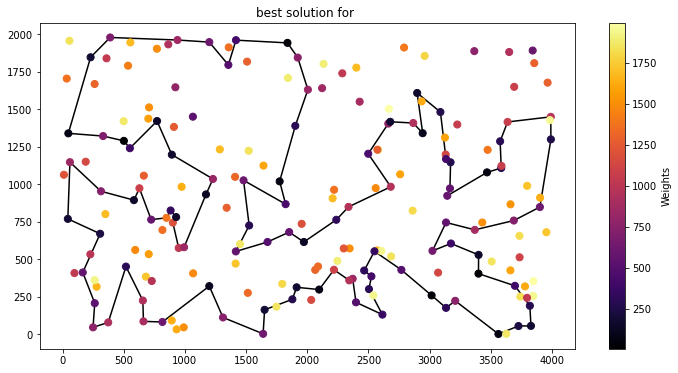

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [92]:
for combination in all_combinations:
    test_method(neighborhood, dist, costs, coordinates, pert_f=combination, name=' '.join([str(x) for x in combination]))